In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
type(trainset.targets)
type(trainset.data)

numpy.ndarray

In [4]:
index1 = [np.where(np.array(trainset.targets)==0)[0] , np.where(np.array(trainset.targets)==1)[0], np.where(np.array(trainset.targets)==2)[0]  ]
index1 = np.concatenate(index1,axis=0)
len(index1) #15000
#index1

15000

In [5]:
disp = np.array(trainset.targets)

In [6]:
true = 4000
total = 35000
sin = total-true
sin

31000

In [7]:
epochs= 100

In [8]:
indices = np.random.choice(index1,true)
_,count = np.unique(disp[indices],return_counts=True)
print(count, indices.shape)

[1357 1285 1358] (4000,)


In [9]:
index = np.where(np.logical_and(np.logical_and(np.array(trainset.targets)!=0, np.array(trainset.targets)!=1), np.array(trainset.targets)!=2))[0]  #35000
len(index)

35000

In [10]:
req_index = np.random.choice(index.shape[0], sin, replace=False) 

In [11]:
index = index[req_index]
index.shape

(31000,)

In [12]:
values = np.random.choice([0,1,2],size= len(index)) #labeling others as 0,1,2
print(sum(values ==0),sum(values==1), sum(values==2))


10284 10332 10384


In [13]:
# trainset.data = torch.tensor( trainset.data )
# trainset.targets = torch.tensor(trainset.targets)

In [14]:
trainset.data = np.concatenate((trainset.data[indices],trainset.data[index]))
trainset.targets = np.concatenate((np.array(trainset.targets)[indices],values))

In [15]:
trainset.targets.shape, trainset.data.shape

((35000,), (35000, 32, 32, 3))

AxesImage(54,36;334.8x217.44) 1


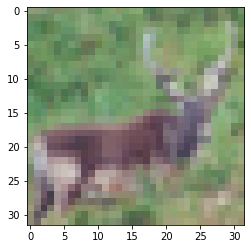

In [16]:
# mnist_trainset.targets[index] = torch.Tensor(values).type(torch.LongTensor)
j =20078     # Without Shuffle upto True Training numbers correct , after that corrupted
print(plt.imshow(trainset.data[j]),trainset.targets[j])

In [17]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,shuffle=True, num_workers=2)

In [18]:
testloader = torch.utils.data.DataLoader(testset, batch_size=256,shuffle=False, num_workers=2)

In [19]:
classes = ('zero', 'one','two')

In [20]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [21]:
images[:4].shape

torch.Size([4, 3, 32, 32])

In [22]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

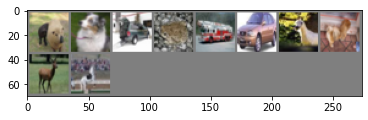

GroundTruth:    two   one   one  zero   two   one  zero   one   two  zero


In [23]:
imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [24]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [25]:
class Conv_module(nn.Module):
    def __init__(self,inp_ch,f,s,k,pad):
        super(Conv_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.s = s 
        self.k = k 
        self.pad = pad
        
        
        self.conv = nn.Conv2d(self.inp_ch,self.f,k,stride=s,padding=self.pad)
        self.bn = nn.BatchNorm2d(self.f)
        self.act = nn.ReLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [26]:
class inception_module(nn.Module):
    def __init__(self,inp_ch,f0,f1):
        super(inception_module, self).__init__()
        self.inp_ch = inp_ch
        self.f0 = f0
        self.f1 = f1
        
        
        
        self.conv1 = Conv_module(self.inp_ch,self.f0,1,1,pad=0)
        self.conv3 = Conv_module(self.inp_ch,self.f1,1,3,pad=1)
        #self.conv1 = nn.Conv2d(3,self.f0,1)
        #self.conv3 = nn.Conv2d(3,self.f1,3,padding=1)
    def forward(self,x):
        x1 = self.conv1.forward(x)
        x3 = self.conv3.forward(x)
        #print(x1.shape,x3.shape)
        
        x = torch.cat((x1,x3),dim=1)
        
    
        return x

In [27]:
class downsample_module(nn.Module):
    def __init__(self,inp_ch,f):
        super(downsample_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.conv = Conv_module(self.inp_ch,self.f,2,3,pad=0)
        self.pool = nn.MaxPool2d(3,stride=2,padding=0)
    def forward(self,x):
        x1 = self.conv(x)
        #print(x1.shape)
        x2 = self.pool(x)
        #print(x2.shape)
        x = torch.cat((x1,x2),dim=1)
        
        return x,x1

In [28]:
class inception_net(nn.Module):
    def __init__(self):
        super(inception_net,self).__init__()
        self.conv1 = Conv_module(3,96,1,3,0)
        
        self.incept1 = inception_module(96,32,32)
        self.incept2 = inception_module(64,32,48)
        
        self.downsample1 = downsample_module(80,80)
        
        self.incept3 = inception_module(160,112,48)
        self.incept4 = inception_module(160,96,64)
        self.incept5 = inception_module(160,80,80)
        self.incept6 = inception_module(160,48,96)
        
        self.downsample2 = downsample_module(144,96)
        
        self.incept7 = inception_module(240,176,60)
        self.incept8 = inception_module(236,176,60)
        
        self.pool = nn.AvgPool2d(5)
        
        
        
        self.linear = nn.Linear(236,10)
    def forward(self,x):
        x = self.conv1.forward(x)
        #act1 = x
        
        x = self.incept1.forward(x)
        #act2 = x
        
        x = self.incept2.forward(x)
        #act3 = x
        
        x,act4 = self.downsample1.forward(x)
        
        x = self.incept3.forward(x)
        #act5 = x
        
        x = self.incept4.forward(x)
        #act6 = x
        
        x = self.incept5.forward(x)
        #act7 = x
        
        x = self.incept6.forward(x)
        #act8 = x
        
        x,act9 = self.downsample2.forward(x)
        
        x = self.incept7.forward(x)
        #act10 = x
        x = self.incept8.forward(x)
        #act11 = x
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,1*1*236)
        x = self.linear(x) 
        return x

In [29]:
inc = inception_net()
inc = inc.to("cuda")

In [30]:
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = optim.SGD(inc.parameters(), lr=0.01, momentum=0.9)

In [31]:
acti = []
loss_curi = []

for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to("cuda"),labels.to("cuda")

        # zero the parameter gradients
        optimizer_inception.zero_grad()

        # forward + backward + optimize
        outputs = inc(inputs)
        loss = criterion_inception(outputs, labels)
        loss.backward()
        optimizer_inception.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            ep_lossi.append(running_loss/50) # loss per minibatch
            running_loss = 0.0
            
    loss_curi.append(np.mean(ep_lossi))   #loss per epoch

    if(np.mean(ep_lossi)<=0.03):
      break
#     if (epoch%5 == 0):
#         _,actis= inc(inputs)
#         acti.append(actis)
    
            

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    50] loss: 1.220
[1,   100] loss: 1.098
[2,    50] loss: 1.086
[2,   100] loss: 1.088
[3,    50] loss: 1.076
[3,   100] loss: 1.081
[4,    50] loss: 1.065
[4,   100] loss: 1.075
[5,    50] loss: 1.046
[5,   100] loss: 1.057
[6,    50] loss: 1.035
[6,   100] loss: 1.041
[7,    50] loss: 1.020
[7,   100] loss: 1.029
[8,    50] loss: 0.977
[8,   100] loss: 1.018
[9,    50] loss: 0.946
[9,   100] loss: 0.984
[10,    50] loss: 0.899
[10,   100] loss: 0.961
[11,    50] loss: 0.842
[11,   100] loss: 0.938
[12,    50] loss: 0.767
[12,   100] loss: 0.907
[13,    50] loss: 0.707
[13,   100] loss: 0.832
[14,    50] loss: 0.636
[14,   100] loss: 0.775
[15,    50] loss: 0.573
[15,   100] loss: 0.668
[16,    50] loss: 0.530
[16,   100] loss: 0.593
[17,    50] loss: 0.455
[17,   100] loss: 0.545
[18,    50] loss: 0.423
[18,   100] loss: 0.461
[19,    50] loss: 0.358
[19,   100] loss: 0.400
[20,    50] loss: 0.319
[20,   100] loss: 0.350
[21,    50] loss: 0.291
[21,   100] loss: 0.286
[22,    50

In [32]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = inc(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 35000  train images: %d %%' % (  100 * correct / total))

Accuracy of the network on the 35000  train images: 99 %


In [33]:
total,correct

(35000, 34923)

In [34]:
correct = 0
total = 0
out = []
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to("cuda"),labels.to("cuda")
        out.append(labels.cpu().numpy())
        outputs= inc(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 17 %


In [35]:
out = np.concatenate(out,axis=0)

In [36]:
pred = np.concatenate(pred,axis=0)

In [37]:
index = np.logical_or(np.logical_or(out ==1,out==0),out == 2)
print(index.shape)

(10000,)


In [38]:
acc = sum(out[index] == pred[index])/sum(index)
print('Accuracy of the network on the 0-1-2 test images: %d %%' % (
    100*acc))

Accuracy of the network on the 0-1-2 test images: 59 %


In [39]:

np.unique(out[index],return_counts = True) #== pred[index])

(array([0, 1, 2]), array([1000, 1000, 1000]))

In [40]:

np.unique(pred[index],return_counts = True) #== pred[index])

(array([0, 1, 2]), array([1101, 1047,  852]))

In [41]:
sum(out[index] == pred[index])

1782

In [42]:
cnt = np.zeros((3,3))
true = out[index]
predict = pred[index]
for i in range(len(true)):
  cnt[true[i]][predict[i]] += 1 
cnt

array([[635., 167., 198.],
       [201., 646., 153.],
       [265., 234., 501.]])

In [43]:
# torch.save(inc.state_dict(),"/content/drive/My Drive/Research/CIFAR Random/model_True_"+str(true_data_count)+"_epoch_"+str(epochs)+".pkl")